# 04. Model Tuning

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load preprocessed data from previous notebook
print("Loading processed data...")
with open('../data/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

Loading processed data...


In [18]:
# Extract data components
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
test_ID = data['test_ID']
numeric_features = data['numeric_features']
categorical_features = data['categorical_features']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2051, 23)
Test data shape: (878, 23)


In [19]:
# Add this right after loading your data
print("y_train summary statistics:")
print("Min:", np.min(y_train))
print("Max:", np.max(y_train))
print("Mean:", np.mean(y_train))
print("Are there any values > 100?", np.any(y_train > 100))

# If y_train is properly log-transformed, values should typically be between 0-20
# House prices in log scale would not be in the hundreds of thousands

y_train summary statistics:
Min: 12789
Max: 611657
Mean: 181469.70160897123
Are there any values > 100? True


In [20]:
# Add this after data loading and before model tuning
print("Applying log transformation to y_train...")
y_train_original = y_train.copy()  # Keep original for reference
y_train = np.log1p(y_train)  # Properly transform the target

Applying log transformation to y_train...


In [21]:
# Load the best model info from benchmarking
try:
    print("Loading best model from benchmarking step...")
    with open('../data/best_model.pkl', 'rb') as f:
        best_benchmark_model = pickle.load(f)
    
    # Use the model class from benchmark to determine which model to tune
    if hasattr(best_benchmark_model, 'named_steps'):
        model_class = best_benchmark_model.named_steps['model'].__class__.__name__
    else:
        model_class = best_benchmark_model.__class__.__name__
    print(f"Best model from benchmarking: {model_class}")
except:
    print("No best model file found from benchmarking. Using Ridge and Lasso as default.")
    model_class = "Ridge"  # Default to Ridge if no best model found


Loading best model from benchmarking step...
Best model from benchmarking: Ridge


## 1. Setting up Preprocessing Pipeline

In [22]:
print("\n=== SETTING UP PREPROCESSING PIPELINE ===")

# For numerical features: impute and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create preprocessor - robust to having no categorical features
transformers = [('num', numeric_transformer, numeric_features)]
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)


=== SETTING UP PREPROCESSING PIPELINE ===


## 2. Hyperparameter Tuning for Ridge Regression


=== HYPERPARAMETER TUNING ===

1. Detailed Ridge Regression Tuning
Basic model fits successfully!
Sample predictions (log scale): [12.1919468  12.32267691 11.83860709 11.92428019 11.82872797]
Sample predictions (original scale): [197193.69171213 224733.93361422 138496.43507005 150885.04942417
 137134.93990006]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Ridge alpha: 8.8587
Best Ridge log-space CV RMSE: 0.13540
Best Ridge dollar-space RMSE: $25290.48


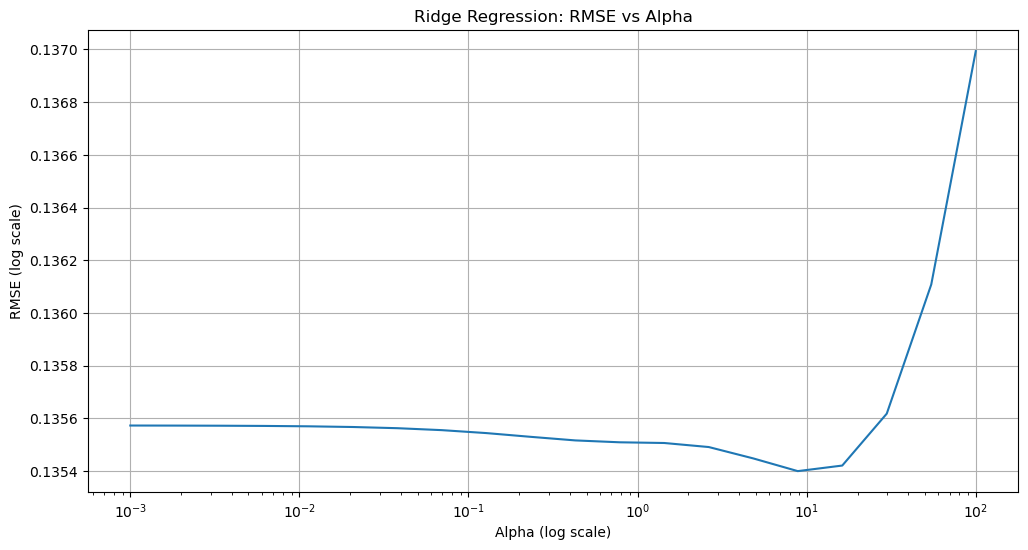

In [23]:
from sklearn.metrics import make_scorer
print(f"\n=== HYPERPARAMETER TUNING ===")

tuning_results = {}

# Ridge Regression Tuning (always included)
# Ridge Regression Tuning (always included)
if model_class in ["Ridge", "LinearRegression"] or model_class == "":
    print("\n1. Detailed Ridge Regression Tuning")
    
    # Create pipeline
    ridge_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=1.0, max_iter=2000))
    ])
    
    # Verify the simple model works
    try:
        ridge_pipeline.fit(X_train, y_train)
        print("Basic model fits successfully!")
        
        # Test predictions to check for numeric issues
        test_pred = ridge_pipeline.predict(X_train[:5])
        print("Sample predictions (log scale):", test_pred)
        print("Sample predictions (original scale):", np.expm1(test_pred))
    except Exception as e:
        print(f"Error in basic model: {e}")
    
    # Define parameter grid - try many alpha values on a logarithmic scale
    ridge_param_grid = {
        'model__alpha': np.logspace(-3, 2, 20)  # More focused range
    }
    
    # Set up grid search - using standard RMSE in log space
    ridge_grid = GridSearchCV(
        ridge_pipeline,
        ridge_param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',  # Evaluate in log space
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    ridge_grid.fit(X_train, y_train)
    
    # Report results
    print(f"Best Ridge alpha: {ridge_grid.best_params_['model__alpha']:.4f}")
    print(f"Best Ridge log-space CV RMSE: {-ridge_grid.best_score_:.5f}")
    
    # Calculate dollar-space RMSE for the best model
    best_ridge = ridge_grid.best_estimator_
    y_pred_log = best_ridge.predict(X_train)
    y_pred_dollars = np.expm1(y_pred_log)
    y_true_dollars = np.expm1(y_train)
    dollar_rmse = np.sqrt(mean_squared_error(y_true_dollars, y_pred_dollars))
    print(f"Best Ridge dollar-space RMSE: ${dollar_rmse:.2f}")
    
    # Store results
    tuning_results['Ridge'] = {
        'best_params': ridge_grid.best_params_,
        'cv_rmse': -ridge_grid.best_score_,  # Log space RMSE
        'dollar_rmse': dollar_rmse,          # Dollar space RMSE
        'model': ridge_grid.best_estimator_
    }
    
    # Plot alpha vs RMSE
    ridge_results = pd.DataFrame(ridge_grid.cv_results_)
    plt.figure(figsize=(12, 6))
    plt.semilogx(ridge_results['param_model__alpha'], -ridge_results['mean_test_score'])
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('RMSE (log scale)')
    plt.title('Ridge Regression: RMSE vs Alpha')
    plt.grid(True)
    plt.savefig('../images/ridge_tuning.png')
    plt.show()

## 3. Compared Tuned Models


=== COMPARING TUNED MODELS ===
   Model  CV RMSE                           Parameters
0  Ridge   0.1354  {'model__alpha': 8.858667904100823}


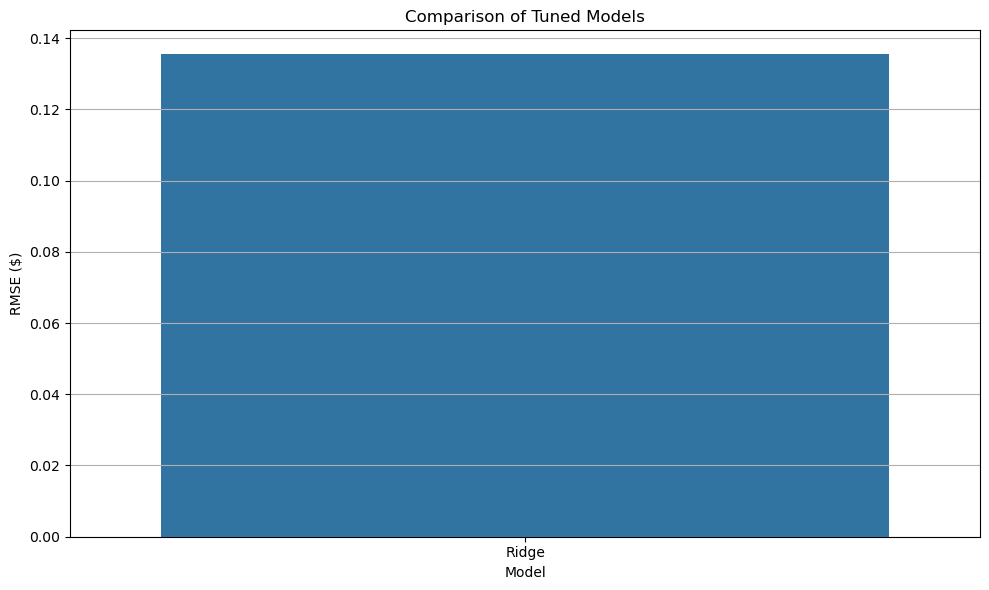

In [24]:
print("\n=== COMPARING TUNED MODELS ===")

# Create comparison DataFrame
tuned_df = pd.DataFrame({
    'Model': list(tuning_results.keys()),
    'CV RMSE': [tuning_results[m]['cv_rmse'] for m in tuning_results],
    'Parameters': [str(tuning_results[m]['best_params']) for m in tuning_results]
})

# Sort by CV RMSE
tuned_df = tuned_df.sort_values('CV RMSE')
print(tuned_df)

# Visualize results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='CV RMSE', data=tuned_df)
plt.title('Comparison of Tuned Models')
plt.ylabel('RMSE ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../images/tuned_models_comparison.png')
plt.show()

## 4. Selecting Final Model and Saving

In [25]:
best_model_name = tuned_df.iloc[0]['Model']
best_model = tuning_results[best_model_name]['model']
best_params = tuning_results[best_model_name]['best_params']
best_rmse = tuned_df.iloc[0]['CV RMSE']

print(f"\n=== BEST MODEL ===")
print(f"Model: {best_model_name}")
print(f"Parameters: {best_params}")
print(f"CV RMSE: ${best_rmse:.2f}")

# Compare with previous best model (if available)
try:
    # Get cross-validation score for previous best model from benchmarking
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    prev_scores = cross_val_score(
        best_benchmark_model, 
        X_train, 
        y_train, 
        cv=kf,
        scoring='neg_root_mean_squared_error'
    )
    prev_rmse = -prev_scores.mean()
    
    # Calculate improvement
    improvement = prev_rmse - best_rmse
    percent_improvement = (improvement / prev_rmse) * 100
    
    print(f"\nImprovement over benchmark model:")
    print(f"Benchmark RMSE: ${prev_rmse:.2f}")
    print(f"Tuned RMSE: ${best_rmse:.2f}")
    print(f"Absolute improvement: ${improvement:.2f}")
    print(f"Percentage improvement: {percent_improvement:.2f}%")
except:
    print("\nNo benchmark model found for comparison.")

# Save the final tuned model
with open('../data/final_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Final tuned model saved successfully!")



=== BEST MODEL ===
Model: Ridge
Parameters: {'model__alpha': 8.858667904100823}
CV RMSE: $0.14

Improvement over benchmark model:
Benchmark RMSE: $0.15
Tuned RMSE: $0.14
Absolute improvement: $0.02
Percentage improvement: 10.39%
Final tuned model saved successfully!


## 5. Selecting Final Model and Saving

In [26]:
# 5. Generating Predictions
print("\n=== GENERATING PREDICTIONS ===")
# Make predictions with the final model (these will be log predictions)
log_predictions = best_model.predict(X_test)

# Transform back to original scale
test_predictions = np.expm1(log_predictions)

# Create submission file
final_submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': test_predictions
})

# Ensure predictions are positive
final_submission['SalePrice'] = final_submission['SalePrice'].clip(lower=0)

# Save to CSV
final_submission.to_csv('../data/final_submission.csv', index=False)
print("Final submission file created successfully!")


=== GENERATING PREDICTIONS ===
Final submission file created successfully!
